<a href="https://colab.research.google.com/github/Lakshman3556/Machine_Learning/blob/main/week_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing important libraries and functions

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


loading a dataset

In [6]:
filepath2 = '/content/drive/MyDrive/ML/Santander Customer Satisfaction_train.csv'
df2 = pd.read_csv(filepath2)
print(df2.head())

   ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...

In [7]:
[col for col in df2.columns if df2[col].isnull().sum()>0] #checking for null values

[]

Constant Features (columns with constant values)

In [8]:
x_train2 , x_test2 , y_train2 , y_test2 = train_test_split(
    df2.drop(labels=['imp_op_var39_comer_ult3'],axis=1),
    df2['imp_op_var39_comer_ult3'],
    test_size=0.3,
    random_state=0
)

constant_features2 = [ cols for cols in x_train2.columns if x_train2[cols].std() == 0 ]
print(len(constant_features2))

38


In [15]:
x_train2.drop(labels=constant_features2, axis=1, inplace=True, errors='ignore')
x_test2.drop(labels=constant_features2, axis=1, inplace=True, errors='ignore')


Quasi Constant Features (98% of the values of a column are same or constant)

In [16]:
quasi_constant_feature = []

for feature in x_train2.columns:
  predominant = (x_train2[feature].value_counts() / np.float64(len(x_train2))).sort_values(ascending=False).values[0]

  if predominant > 0.999:
    quasi_constant_feature.append(feature)

print(len(quasi_constant_feature))

108


In [17]:
x_train2.drop(labels = quasi_constant_feature , axis=1 , inplace = True)
x_test2.drop(labels = quasi_constant_feature , axis=1 , inplace = True)

Duplicated Columns (Two or More Cols having same duplicated values)

In [18]:
duplicated_feat = []

for i in range(0,len(x_train2.columns)):
  col_1 = x_train2.columns[i]
  for col_2 in x_train2.columns[i+1:]:
    if x_train2[col_1].equals(x_train2[col_2]):
      duplicated_feat.append(col_2)

print(duplicated_feat)

['ind_var26', 'ind_var25', 'ind_var32', 'ind_var37', 'ind_var39', 'num_var26', 'num_var25', 'num_var32', 'num_var37', 'num_var39']


In [19]:
duplicated_features = list(set(duplicated_feat))
x_train2.drop(labels = duplicated_features , axis=1 , inplace = True)
x_test2.drop(labels = duplicated_features , axis=1 , inplace = True)

Corelation Heat Map

<Axes: >

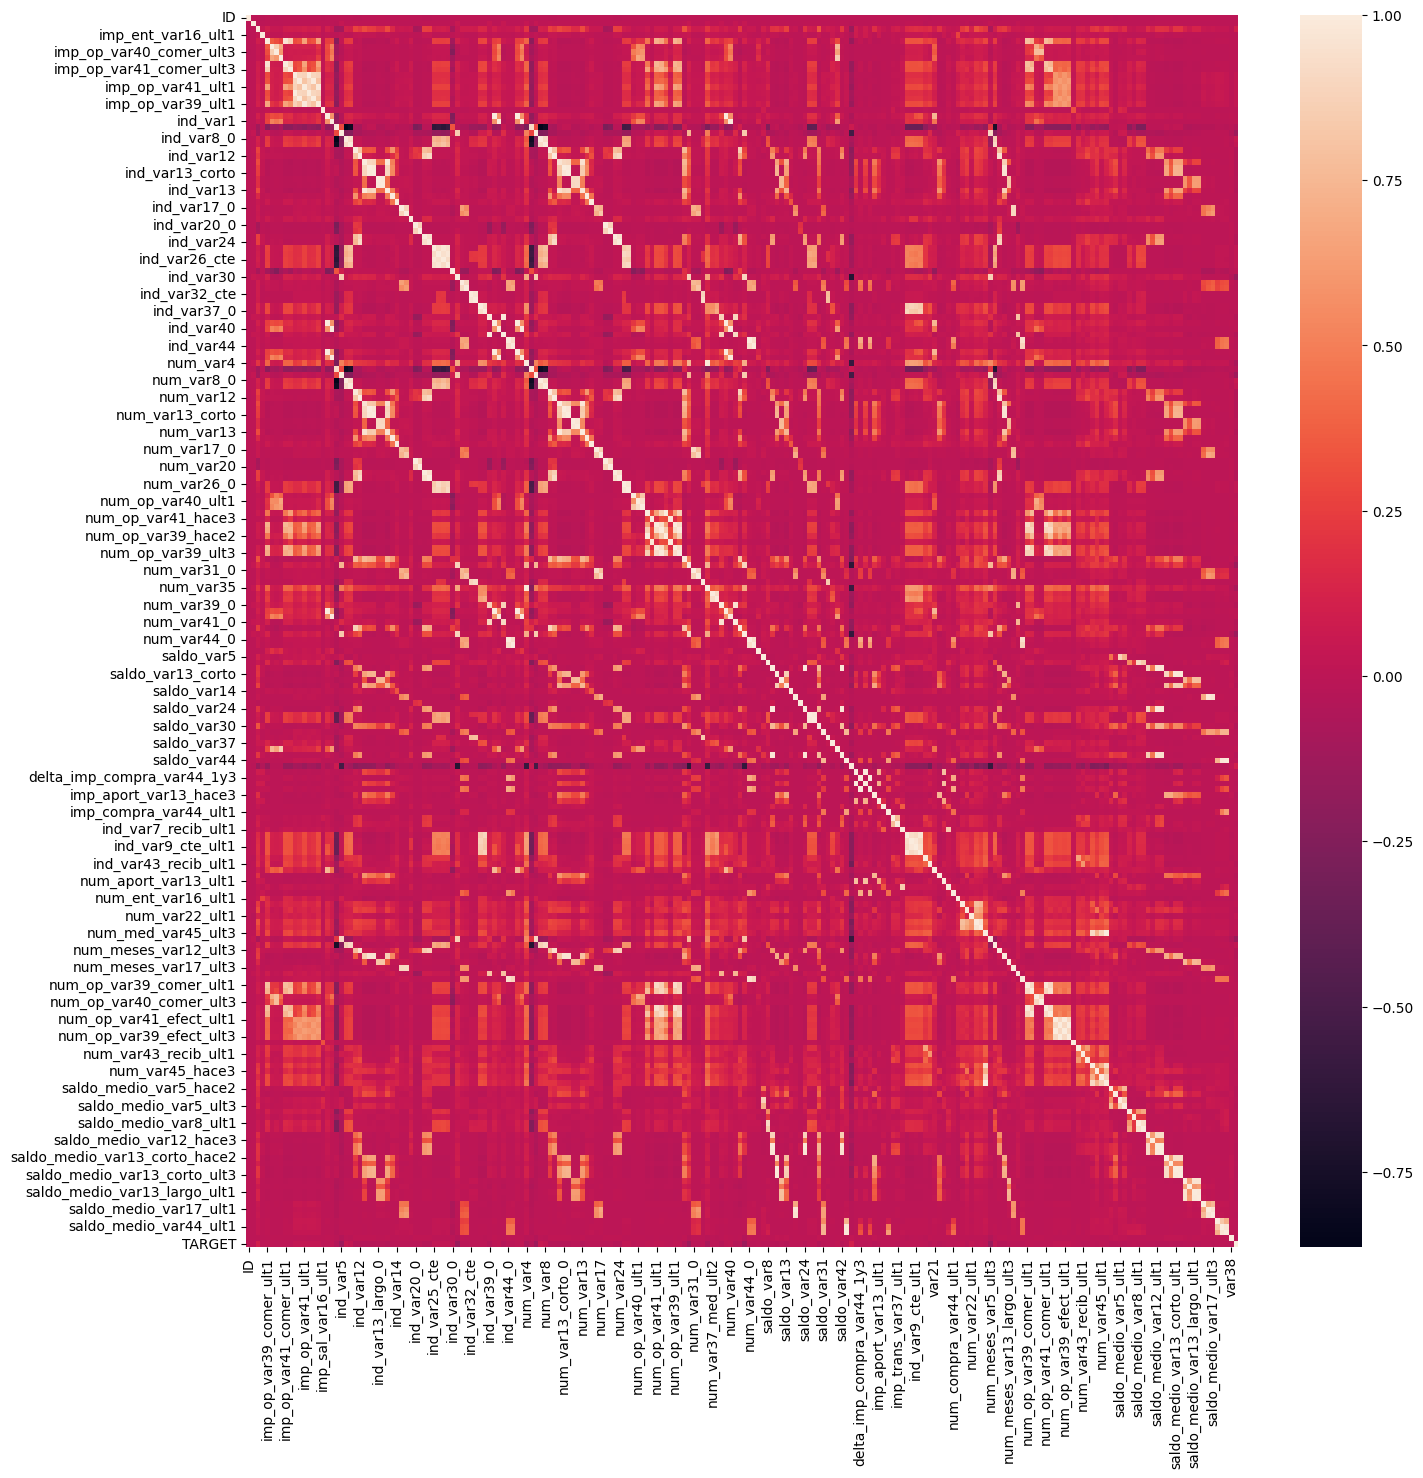

In [20]:
corrmat = x_train2.corr()
fig , ax = plt.subplots()
fig.set_size_inches(16,16)
sns.heatmap(corrmat)

In [21]:
grouped_feature_ls = []
correlated_features_ls = []
def correlation(dataset , threshold):
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

corr_features = correlation(x_train2 , 0.9)
correlated_features = list(set(corr_features))
print(len(correlated_features))

93


In [22]:
x_train2.drop(labels = correlated_features , axis=1 , inplace = True)
x_test2.drop(labels = correlated_features , axis=1 , inplace = True)

Mutual Information

In [23]:
X = df2.drop(columns=['TARGET'])
Y = df2['TARGET']
mi_scores = mutual_info_classif(X,Y)
mi_df = pd.DataFrame({'Feature':X.columns,'Mutual Info Score':mi_scores})
mi_df.sort_values('Mutual Info Score',ascending=False)

,Feature,Mutual Info Score
64,ind_var30,0.025704
91,num_var5,0.024005
25,ind_var5,0.023374
159,num_var42,0.022172
281,num_meses_var5_ult3,0.018898
...,...,...
361,saldo_medio_var33_hace2,0.000000
360,saldo_medio_var29_ult3,0.000000
359,saldo_medio_var29_ult1,0.000000
357,saldo_medio_var29_hace2,0.000000


Chi Square Test to select useful features

In [24]:
X = df2.drop(columns=['TARGET'])
Y = df2['TARGET']
label_encoders = {}
for col in X.columns:
  if X[col].dtype == 'object' :
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Replace negative values with 0
X = X.clip(lower=0)

if Y.dtype == 'object':
  Y = LabelEncoder().fit_transform(Y.astype(str))

chi_score , p_values = chi2(X,Y)
chi_df = pd.DataFrame({'Feature':X.columns,'Chi Square Score':chi_score, 'P Values':p_values})
chi_df.sort_values('Chi Square Score',ascending=False)
print(chi_df)

                     Feature  Chi Square Score      P Values
0                         ID      1.901529e+04  0.000000e+00
1                       var3      2.771607e+02  3.121266e-62
2                      var15      3.944560e+03  0.000000e+00
3         imp_ent_var16_ult1      7.009530e-01  4.024637e-01
4    imp_op_var39_comer_ult1      1.296453e+04  0.000000e+00
..                       ...               ...           ...
365  saldo_medio_var44_hace2      9.867234e+04  0.000000e+00
366  saldo_medio_var44_hace3      5.820919e+03  0.000000e+00
367   saldo_medio_var44_ult1      1.572346e+05  0.000000e+00
368   saldo_medio_var44_ult3      9.930481e+04  0.000000e+00
369                    var38      8.235272e+06  0.000000e+00

[370 rows x 3 columns]


ANOVA

In [25]:
X = df2.drop(columns=['TARGET'])
y = df2['TARGET']
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y.astype(str))
X_num = X.select_dtypes(include=['number'])
f_scores, p_values = f_classif(X_num, y)
f_df = pd.DataFrame({'Feature': X_num.columns, 'F-Score': f_scores, 'P-Value': p_values})
f_df.sort_values('F-Score', ascending=False)
print(f_df)

                     Feature     F-Score        P-Value
0                         ID    0.753563   3.853533e-01
1                       var3    1.522201   2.172905e-01
2                      var15  788.508493  1.302284e-172
3         imp_ent_var16_ult1    0.000023   9.961590e-01
4    imp_op_var39_comer_ult1    8.149037   4.309568e-03
..                       ...         ...            ...
365  saldo_medio_var44_hace2    0.767072   3.811270e-01
366  saldo_medio_var44_hace3    0.495335   4.815594e-01
367   saldo_medio_var44_ult1    0.732275   3.921495e-01
368   saldo_medio_var44_ult3    0.690907   4.058587e-01
369                    var38   28.946035   7.464231e-08

[370 rows x 3 columns]


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 22  23  57  58  59  60  81  85  86 132 133 134 135 156 162 163 180 181
 190 193 221 223 235 239 245 249 262 263 304 308 316 320 328 350] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
